In [1]:
import pandas as pd
import seaborn as sns
from ephesus.data import get_data_json
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [2]:
df = get_data_json()
df.head()

,fichier,translation
0,3e7ffb67-8872-4172-bf18-4fe338ecae3f_64e118fc-...,"Nouvelle ordonnance pour madame Vilain, valabl..."
1,2d035c4b-cdfa-4982-87dc-916fe07a0824_50e8d80a-...,"Prise de sang réalisée au domicile, ce jour, l..."
2,f0caa21b-c11d-40a3-98ec-e2df3d2b9cc4_3ab44a1b-...,Prise de sang réalisée le 12 mai puis le 9 jui...
3,a5050600-95ef-43d8-a5fa-a57c791bf843_2af70417-...,"Injection intramusculaire cet après-midi, pas ..."
4,9f980dcf-b431-4e67-876f-2b8e288b7900_777f3b22-...,Test PCR remboursable fait le 8 février à 11h1...


In [3]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")

In [4]:
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [9]:
sample_size = sample_size = 30
df_sample = df.sample(sample_size).copy()

df_sample["camembert"] = nlp(df_sample["translation"].to_list())
df_sample.head()

,fichier,translation,camembert
669,9d42ce6f-8537-49a9-a121-c8ae1dc7cda8_8dc2f00b-...,"Bon sang, prélèvement des selles par isabelle ...","[{'entity_group': 'PER', 'score': 0.75985837, ..."
3378,a5050600-95ef-43d8-a5fa-a57c791bf843_705bf562-...,Test antigénique réalisé ce soir à domicile se...,[]
1558,2d035c4b-cdfa-4982-87dc-916fe07a0824_2738acaf-...,Réalisation d'un prélèvement nasopharyngé à mo...,"[{'entity_group': 'PER', 'score': 0.88512313, ..."
1824,3e7ffb67-8872-4172-bf18-4fe338ecae3f_1fb436e2-...,Injection intramusculaire réalisé le 27 août à...,"[{'entity_group': 'DATE', 'score': 0.99288464,..."
1720,a5050600-95ef-43d8-a5fa-a57c791bf843_09327b73-...,Test antigénique réalisé cet après-midi à domi...,[]


In [10]:
def keep_date_only(entities_serie):
    return [[entity.get("word") for entity in entities if entity.get("entity_group", "empty") == "DATE"] for entities in entities_serie]

In [11]:
df_sample["date_words"] = keep_date_only(df_sample["camembert"])
df_sample.head()

,fichier,translation,camembert,date_words
669,9d42ce6f-8537-49a9-a121-c8ae1dc7cda8_8dc2f00b-...,"Bon sang, prélèvement des selles par isabelle ...","[{'entity_group': 'PER', 'score': 0.75985837, ...",[]
3378,a5050600-95ef-43d8-a5fa-a57c791bf843_705bf562-...,Test antigénique réalisé ce soir à domicile se...,[],[]
1558,2d035c4b-cdfa-4982-87dc-916fe07a0824_2738acaf-...,Réalisation d'un prélèvement nasopharyngé à mo...,"[{'entity_group': 'PER', 'score': 0.88512313, ...",[le 709 2021 à 7h15]
1824,3e7ffb67-8872-4172-bf18-4fe338ecae3f_1fb436e2-...,Injection intramusculaire réalisé le 27 août à...,"[{'entity_group': 'DATE', 'score': 0.99288464,...",[le 27 août à 11h]
1720,a5050600-95ef-43d8-a5fa-a57c791bf843_09327b73-...,Test antigénique réalisé cet après-midi à domi...,[],[]


In [12]:
df_sample["date_words_len"] = df_sample["date_words"].map(len)
df_sample.head()

,fichier,translation,camembert,date_words,date_words_len
669,9d42ce6f-8537-49a9-a121-c8ae1dc7cda8_8dc2f00b-...,"Bon sang, prélèvement des selles par isabelle ...","[{'entity_group': 'PER', 'score': 0.75985837, ...",[],0
3378,a5050600-95ef-43d8-a5fa-a57c791bf843_705bf562-...,Test antigénique réalisé ce soir à domicile se...,[],[],0
1558,2d035c4b-cdfa-4982-87dc-916fe07a0824_2738acaf-...,Réalisation d'un prélèvement nasopharyngé à mo...,"[{'entity_group': 'PER', 'score': 0.88512313, ...",[le 709 2021 à 7h15],1
1824,3e7ffb67-8872-4172-bf18-4fe338ecae3f_1fb436e2-...,Injection intramusculaire réalisé le 27 août à...,"[{'entity_group': 'DATE', 'score': 0.99288464,...",[le 27 août à 11h],1
1720,a5050600-95ef-43d8-a5fa-a57c791bf843_09327b73-...,Test antigénique réalisé cet après-midi à domi...,[],[],0


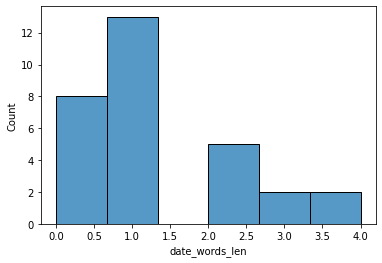

In [13]:
sns.histplot(data=df_sample, x="date_words_len");

In [14]:
df_sample.shape

(30, 5)

## let's see if we're correct when we don't detect any date

On voit qu'on ne détecte pas les "ce jour", "ce matin", "cet apres-midi", etc

In [16]:
mask = df_sample["date_words_len"] == 0
df_zero = df_sample[mask][["translation"]]
for i in range(len(df_zero)):
    print(df_zero.iloc[i].to_list())

['Bon sang, prélèvement des selles par isabelle à domicile.']
['Test antigénique réalisé ce soir à domicile selon ordonnance.']
['Test antigénique réalisé cet après-midi à domicile pas de frais de déplacement.']
['Pansement simple à domicile. Arena belo']
['Soit fait ce jour par pauline sur le remplacement de christelle.']
['Ordonnance pour le renouvellement des soins de monsieur Didier Nicolas, soit un programme et comme habituellement patient en ald, merci.']
['Test PCR réalisé ce matin à domicile. Pas de frais de déplacement.']
['Test, le PCR air réalisé ce matin au cabinet.']


## let's see if we're correct when we detect one date only

On voit que ca fonctionne bien : il n'y avait en effet qu'une date dans le message et on l'a bien detectee

In [17]:
mask = df_sample["date_words_len"] == 1
df_one = df_sample[mask][["translation", "date_words"]]
for i in range(len(df_one)):
    print(df_one.iloc[i].to_list())

["Réalisation d'un prélèvement nasopharyngé à monsieur gatignon enzo. Prélèvement réalisé le 709 2021 à 7h15 au cabinet pour test PCR covid-19 merci.", ['le 709 2021 à 7h15']]
['Injection intramusculaire réalisé le 27 août à 11h. Ne pas compter de domicile.', ['le 27 août à 11h']]
['Prise de sang le 24 septembre.', ['le 24 septembre']]
['Prise de sang réalisée le 8 novembre à 9h à domicile. ', ['le 8 novembre à 9h à']]
["Félix jean, test PCR ce jour, Aubry Sandra, en même temps qu'elle soins à 8h.", ['à 8h']]
['Prise de sang faite ce jour à domicile à 7h06. Pour une patiente en ald.', ['à 7h06']]
['Prise de sang réalisée le 21 janvier en même temps que la sous-cutanée.', ['le 21 janvier en']]
['Vaccin fait le 11/11/2020 au domicile de la patiente merci.', ['le 11/11/2020 au']]
['Test PCR réalisé à domicile ce jour le 9 mars 2022 à 11h10 par aline.', ['le 9 mars 2022 à 11h10']]
['Test pcr pour madame Didier Denise fait le samedi 15 janvier 2022 par sabrina.', ['le samedi 15 janvier 2022

## let's see if we're correct when we detect exactly two dates

In [18]:
mask = df_sample["date_words_len"] == 2
df_two = df_sample[mask][["translation", "date_words"]]
for i in range(len(df_two)):
    print(df_two.iloc[i].to_list())

["Prolongation de l'ordonnance c'est des sous-cutanée, jusqu'au 7 avril. Une injection par jour aux alentours de 17,18h.", ['7 avril', '17,18h']]
["Ordonnance pour la réalisation d'une prise de sang à monsieur Didier Nicolas sang, réaliser. Le 1502 2022 à domicile à 8h30, patient en merci.", ['1502 2022', 'à 8h30,']]
['Bilan sanguin réalisé le mercredi 2 mars matin à domicile.', ['le mercredi 2 mars', 'à']]
["Test antigénique réalisé le 5 avril 2022, suivis d'un test PCR r. À 18h50 par aline.", ['le 5 avril 2022', 'À 18h50']]
["Ordonnance pour la réalisation d'une prise de sang à madame Didier Denise . Prise de sang réalisée le 30 mars 2022 à domicile à 6h45 patient en ald merci.", ['le 30 mars 2022 à', 'à 6h45']]
